In [1]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import random

# Anna
### Takes an image of a tissue slice and an image of an epithelium extract from Qupath an inputs
### Changes from Alyssa:
- first code chunk is new because it uses images from Qupath instead of images from Prashan't epithelium extraction code
- This code patches over the mask instead of the tissue image in order to avoid issues with black or white pixels within the stain

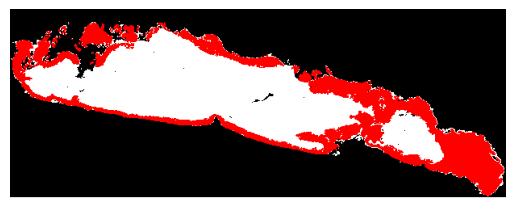

In [2]:
def apply_mask():

    # IMPORTANT !!!
    # the image of the tissue is from qupath and qupath labels it 'thumbnail.jpg'
    # dont use the image straight from onedrive or anything not labeled 'thumbnail.jpg'
    jpg_path = '/Users/annaroney/Downloads/Stat390_Anna/QuPath_work/1:22 patching test/data/2/thumbnail.jpg' # thumbnail jpg
    png_mask_path = '/Users/annaroney/Downloads/Stat390_Anna/QuPath_work/1:22 patching test/export/h1857578B  h&e_ROI_2-labels.png' # mask png
    
    jpg_image = Image.open(jpg_path).convert("RGB")
    png_mask = Image.open(png_mask_path).convert("RGBA")

    # Resize the mask to match the JPG dimensions if they differ
    if jpg_image.size != png_mask.size:
        png_mask = png_mask.resize(jpg_image.size, Image.LANCZOS)

    # Convert both images to numpy arrays
    jpg_array = np.array(jpg_image)
    mask_array = np.array(png_mask)

    # Create a mask for the PNG: True where the PNG is not white
    non_white_mask = ~np.all(mask_array[:, :, :3] > 200, axis=-1)  # Mask where PNG is not white

    # Create the final output image with a black background
    final_image_array = np.zeros_like(jpg_array)

    # Add white for stroma: Original white pixels in the JPG
    stroma_mask = np.all(jpg_array > 200, axis=-1)  # White pixels in JPG
    final_image_array[stroma_mask] = [0, 0, 0]  # Set stroma to white

    # Add red for mask: Areas in the PNG mask
    final_image_array[non_white_mask] = [254, 0, 0]  # Set mask areas to red
    mask = final_image_array
    # Set remaining original JPG pixels (not covered by PNG) to black
    non_masked_area = ~(stroma_mask | non_white_mask)  # Pixels not in stroma or mask
    final_image_array[non_masked_area] = [255, 255, 255]  # Set uncovered pixels to black

    # Convert back to PIL image
    final_image = Image.fromarray(final_image_array)

    return final_image, mask


image, mask = apply_mask()
filename = '/Users/annaroney/Downloads/Stat390_Anna/data/epithelium.png' # where you want your output to go
image.save(filename)

# Display the final image
plt.imshow(image)
plt.axis("off")
plt.show()

mask[mask == 255] = 0 
# mask = Image.fromarray(mask)
# mask

# Alyssa patching code with Kota dynamic parameter intialization

### Using Alyssa's code as a base, dynamically changing the initial_size parameter to make patches more efficient

Tissue orientation: horizontal


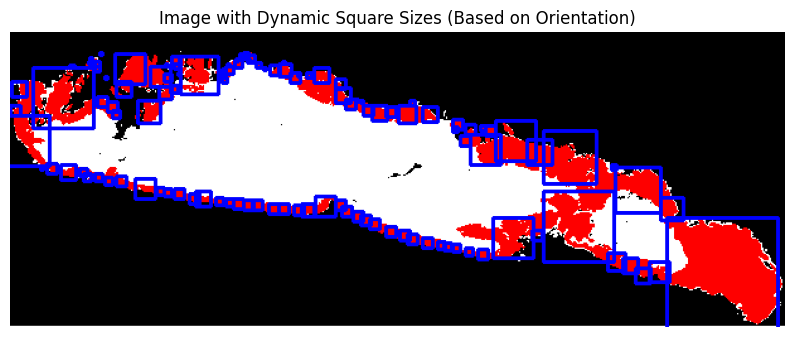

In [4]:
# Load the image
image_path = filename
image = cv2.imread(image_path)

# Function to check if a region contains black, white, and non-black-white mask
def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

# Mask for black areas, white areas, and non-black-white pixels
black_mask = cv2.inRange(image, np.array([0, 0, 0]), np.array([0, 0, 0]))
white_mask = cv2.inRange(image, np.array([255, 255, 255]), np.array([255, 255, 255]))
non_black_white_mask = mask
non_black_white_mask = np.any(non_black_white_mask ==254, axis = 2).astype(int)

# Calculate distance to the nearest black and white pixels
black_distance = cv2.distanceTransform(255 - black_mask, cv2.DIST_L2, 3)
white_distance = cv2.distanceTransform(255 - white_mask, cv2.DIST_L2, 3)

# Find coordinates of non-black and non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Define the ratio tolerance range for balanced points
min_ratio, max_ratio = .7, 1.3

# Filter coordinates to only include balanced points
balanced_points = [
    coord for coord in coordinates
    if min_ratio <= (black_distance[coord[0], coord[1]] / white_distance[coord[0], coord[1]]) <= max_ratio
]

# Function to determine tissue orientation
def determine_orientation(mask):
    # Find non-zero epithelium pixels
    non_zero_coords = np.column_stack(np.where(mask > 0))
    y_min, y_max = non_zero_coords[:, 0].min(), non_zero_coords[:, 0].max()
    x_min, x_max = non_zero_coords[:, 1].min(), non_zero_coords[:, 1].max()
    # Compare height and width of the bounding box
    height = y_max - y_min
    width = x_max - x_min
    return "vertical" if height > width else "horizontal"

# Determine tissue orientation
tissue_orientation = determine_orientation(non_black_white_mask)
print(f"Tissue orientation: {tissue_orientation}")

# Updated function to calculate epithelium width
def calculate_epithelium_width(row_or_col, mask, orientation):
    if orientation == "horizontal":
        # Use vertical slice for horizontally oriented tissue
        slice_mask = mask[:, row_or_col] # looks at the column
    else:
        # Use horizontal slice for vertically oriented tissue
        slice_mask = mask[row_or_col, :]

    # Convert the mask slice to binary (0 or 1)
    binary_slice = (slice_mask > 0).astype(int)

    # Count the maximum number of consecutive ones (nonzero values)
    max_width = 0
    current_width = 0
    for value in binary_slice: # value is an array
        if value == 1:
            current_width += 1
            max_width = max(max_width, current_width)
        else:
            current_width = 0

    return max_width

# Function to calculate overlap
def calculate_overlap(new_coords, existing_coords):
    overlap = len(new_coords.intersection(existing_coords)) / len(new_coords)
    return overlap

# Initialize variables
max_attempts = 1000
covered_coordinates = set()
rectangles = []
attempts = 0

# Start generating squares using only balanced points as starting locations
while len(balanced_points) > 0 and attempts < max_attempts:
    attempts += 1
    # Randomly select a new center point for the square from balanced points
    random.seed(attempts)
    random_coord = random.choice(balanced_points)
    center_x, center_y = int(random_coord[1]), int(random_coord[0])

    # Dynamically calculate the initial_size based on epithelium width
    if tissue_orientation == "horizontal":
        epithelium_width = calculate_epithelium_width(center_x, non_black_white_mask, tissue_orientation)
    else:
        epithelium_width = calculate_epithelium_width(center_y, non_black_white_mask, tissue_orientation)
    
    if epithelium_width < 20:
        initial_size = max(1, round(0.1 * epithelium_width))
    elif epithelium_width < 30:
        initial_size = round(0.15 * epithelium_width)
    elif epithelium_width < 50:
        initial_size = round(0.2 * epithelium_width)
    else:
        initial_size = round(0.4 * epithelium_width)

    num_squares_drawn = 0
    vertical_preference = False

    # Expansion phase for square
    while True:
        size = initial_size * (num_squares_drawn + 1)
        top, bottom = center_y - size, center_y + size
        left, right = center_x - size, center_x + size

        # Define regions at each corner of the square
        corner_checks = {
            "top_left": (top, left),
            "top_right": (top, right - initial_size),
            "bottom_left": (bottom - initial_size, left),
            "bottom_right": (bottom - initial_size, right - initial_size)
        }

        # Track how many corners are outside the mask
        corners_outside_count = 0

        for corner_name, (corner_y, corner_x) in corner_checks.items():
            # Ensure the region is within the image bounds
            if corner_y < 0 or corner_x < 0 or corner_y + initial_size > image.shape[0] or corner_x + initial_size > image.shape[1]:
                corners_outside_count += 1
                continue

            # Extract the corner region in the mask at this corner
            corner_region = non_black_white_mask[corner_y:corner_y + initial_size, corner_x:corner_x + initial_size]
            if not np.any(corner_region):
                corners_outside_count += 1

            if corners_outside_count >= 2:
                break

        if corners_outside_count >= 2:
            break  # Stop expanding

        num_squares_drawn += 1
        if num_squares_drawn > 15:  # Limit expansion if square becomes too large
            break

    # Get all coordinates in the current square
    new_square_coords = set((y, x) for y in range(max(0, top), min(image.shape[0], bottom))
                                    for x in range(max(0, left), min(image.shape[1], right)))
    # Check overlap with existing covered coordinates
    if calculate_overlap(new_square_coords, covered_coordinates) <= 0.2:
        covered_coordinates.update(new_square_coords)
        rectangles.append((left, top, right, bottom))

        # Draw the rectangle
        color = (0, 255, 0) if vertical_preference else (255, 0, 0)
        cv2.rectangle(image, (left, top), (right, bottom), color, 2)

        # Remove these coordinates from the non-black-white mask list and balanced points
        coordinates = np.array([coord for coord in coordinates if tuple(coord) not in new_square_coords])
        balanced_points = [coord for coord in balanced_points if tuple(coord) not in new_square_coords]

# Display the resulting image with all rectangles
plt.figure(figsize=(10, 10))
plt.title("Image with Dynamic Square Sizes (Based on Orientation)")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Jake 

### Calculating evaluation metrics

- % of mask area covered
- % of patch area outside mask
- \# of patches
- % patch area overlap

In [5]:
# Calculate the total mask area
total_mask_area = np.sum(non_black_white_mask > 0)

# Initialize variables to track patch areas and overlap
total_patch_area = 0            
patch_area_outside_mask = 0     
overlap_area = 0                

patch_masks = [] # stores binary masks for each patch so we can calculate overlaps later

# Loop through each patch defined by its bounding box
for (left, top, right, bottom) in rectangles:

    # Create a binary mask for the current patch
    patch_mask = np.zeros_like(non_black_white_mask, dtype=np.uint8)
    patch_mask[max(0, top):min(image.shape[0], bottom), max(0, left):min(image.shape[1], right)] = 1 # set the region corresponding to the current patch to 1 within image bounds

    # Calculate the area of the current patch
    patch_area = np.sum(patch_mask)
    total_patch_area += patch_area    

    # Calculate the area of the patch that falls outside the mask
    area_outside_mask = np.sum(patch_mask & (non_black_white_mask == 0))
    patch_area_outside_mask += area_outside_mask  

    # Calculate overlap with previously added patches
    for prev_patch in patch_masks:
        overlap_area += np.sum(patch_mask & prev_patch)

    # Add the current patch's binary mask to the list for future overlap calculations
    patch_masks.append(patch_mask)

# Percentage calculations
percent_mask_covered = (total_patch_area - patch_area_outside_mask) / total_mask_area * 100
percent_outside_mask = patch_area_outside_mask / total_patch_area * 100
percent_overlap = overlap_area / total_patch_area * 100

# Number of patches
num_patches = len(rectangles)

# Output results
print(f"% of Mask Area Covered: {percent_mask_covered:.2f}%")
print(f"% of Patch Area Outside Mask: {percent_outside_mask:.2f}%")
print(f"Number of Patches: {num_patches}")
print(f"% Patch Area Overlap: {percent_overlap:.2f}%")

% of Mask Area Covered: 86.91%
% of Patch Area Outside Mask: 42.48%
Number of Patches: 118
% Patch Area Overlap: 2.96%


# Visualizing Metrics

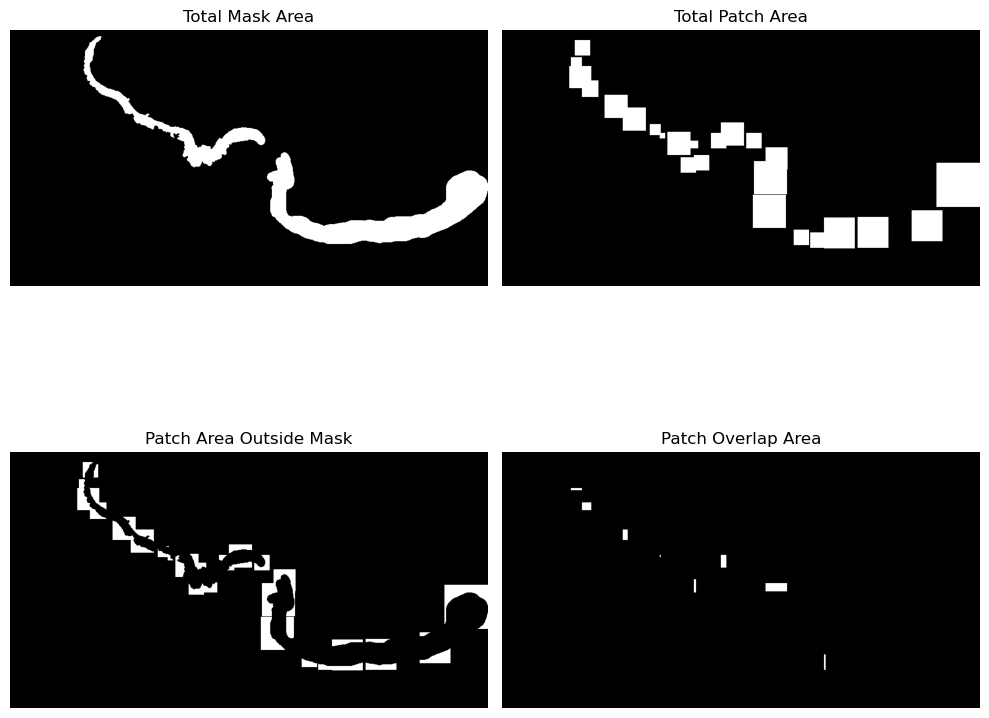

In [46]:
# Create blank images for visualization
mask_visual = non_black_white_mask.copy()
patch_visual = np.zeros_like(non_black_white_mask, dtype=np.uint8)
patch_outside_mask_visual = np.zeros_like(non_black_white_mask, dtype=np.uint8)
patch_overlap_visual = np.zeros_like(non_black_white_mask, dtype=np.uint8)

patch_masks = []  # Store individual patch masks to calculate overlap

for (left, top, right, bottom) in rectangles:
    # Create binary mask for the current patch
    patch_mask = np.zeros_like(non_black_white_mask, dtype=np.uint8)
    patch_mask[max(0, top):min(image.shape[0], bottom), max(0, left):min(image.shape[1], right)] = 255

    # Add patch to total patch visualization
    patch_visual = np.maximum(patch_visual, patch_mask)

    # Ensure mask is in the correct data type and size
    non_black_white_mask_bin = (non_black_white_mask > 0).astype(np.uint8) * 255  # Convert to 0 or 255 (black or white)
    patch_mask_bin = (patch_mask > 0).astype(np.uint8) * 255  # Convert to 0 or 255 (black or white)

    # Ensure both are the same shape
    non_black_white_mask_bin = cv2.resize(non_black_white_mask_bin, (patch_mask_bin.shape[1], patch_mask_bin.shape[0]))

    # Calculate area outside the mask
    outside_mask = cv2.bitwise_and(patch_mask_bin, cv2.bitwise_not(non_black_white_mask_bin))
    patch_outside_mask_visual = np.maximum(patch_outside_mask_visual, outside_mask)

    # Calculate overlapping area with previous patches
    for prev_patch in patch_masks:
        overlap = cv2.bitwise_and(patch_mask, prev_patch)
        patch_overlap_visual = np.maximum(patch_overlap_visual, overlap)

    # Store patch mask
    patch_masks.append(patch_mask)

# Plot the visualizations
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(mask_visual, cmap='gray')
axes[0, 0].set_title("Total Mask Area")

axes[0, 1].imshow(patch_visual, cmap='gray')
axes[0, 1].set_title("Total Patch Area")

axes[1, 0].imshow(patch_outside_mask_visual, cmap='gray')
axes[1, 0].set_title("Patch Area Outside Mask")

axes[1, 1].imshow(patch_overlap_visual, cmap='gray')
axes[1, 1].set_title("Patch Overlap Area")

for ax in axes.flat:
    ax.axis("off")

plt.tight_layout()
plt.show()